AUTHORS: Alejandro

In [1]:
import pandas as pd
import numpy as np
import os 
import torch_geometric.transforms as T
import torch
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
import torch_geometric
from torch_geometric.nn import SAGEConv, to_hetero
from   torch.utils.data      import Dataset, DataLoader
from   torch_geometric.data  import Data
from   torch_geometric.utils import negative_sampling


from torch_geometric.nn           import SAGEConv, to_hetero
from SIMP_LLM.dataloader_mappings import load_graph,load_csv_as_list


from SIMP_LLM.models              import  GATStack,GNNStack,LinkPredictorMLP,CosineSimilarityModel,save_torch_model
from SIMP_LLM.train_utils         import  forward_pass, train,evaluate,   filter_edge_index_by_value,split_edge_index,get_negative_edges

import matplotlib.pyplot as plt #needed to visualize loss curves
import numpy as np 

from sklearn         import metrics
from sklearn.metrics import ConfusionMatrixDisplay


import copy

/opt/conda/envs/simp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Graph

In [2]:
#triplets =[('Compound', 'Compound_treats_the_disease', 'Disease')] # Uncomment this line 
triplets     = load_csv_as_list('triplets.csv')                     # triplets of form (tail, relationship,head)
data         = load_graph(triplets )                                # Load Graph based on triplets (You can selet the triplets 
dictionaries = torch.load("data2/mapping_dict")
#print(data)
#print(data["Compound", "Compound_treats_the_disease", "Disease"].edge_index)

data2


## GRAPH SAGE

#### 1 Masking Sanity Check

In [3]:
edge_index = torch.tensor([[0, 0, 0, 1, 1, 2, 2, 3,4,5,5,5,5,5], [1, 2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14]])
print(f"Oringal Edge index:\n{edge_index }\n: {edge_index.shape}\n")
edge_index_1 , edge_index_2 = split_edge_index(edge_index ,percentage = 0.5,verbose=True)

Oringal Edge index:
tensor([[ 0,  0,  0,  1,  1,  2,  2,  3,  4,  5,  5,  5,  5,  5],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])
: torch.Size([2, 14])

##############
Edge Index 1: torch.Size([2, 5])

Edge Index 2: torch.Size([2, 9])
##############


### 2 Mask Real Data 

In [4]:
## SPLIT TRAIN, TEST, VAL
edge_index_train , edge_index_validation_test          = split_edge_index(edge_index = data["Compound", "Compound_treats_the_disease", "Disease"].edge_index ,percentage = 0.9,verbose=True)
edge_index_validation ,edge_index_test                 = split_edge_index(edge_index = edge_index_validation_test  ,percentage = 0.5,verbose=True)


## Furthere split into EMBED and PREDICT for every split ###
edge_index_train_embed , edge_index_train_predict      = split_edge_index(edge_index = edge_index_train ,percentage = 0.8,verbose=True)
edge_index_val_embed   , edge_index_val_predict        = split_edge_index(edge_index = edge_index_validation   ,percentage = 0.85,verbose=True)
edge_index_test_embed  , edge_index_test_predict       = split_edge_index(edge_index = edge_index_validation   ,percentage = 0.85,verbose=True)





### Train ###
data_train_embed = copy.deepcopy(data)
data_train_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_train_embed
print(data_train_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)

data_train_predict = copy.deepcopy(data)
data_train_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_train_predict 
print(data_train_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)

### Val ###
data_val_embed = copy.deepcopy(data)
data_val_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_val_embed 
print(data_val_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)

data_val_predict = copy.deepcopy(data)
data_val_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_val_predict
print(data_val_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)



### Test ###
data_test_embed = copy.deepcopy(data)
data_test_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_test_embed 
print(data_test_embed["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)

data_test_predict = copy.deepcopy(data)
data_test_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index = edge_index_test_predict
print(data_test_predict["Compound", "Compound_treats_the_disease", "Disease"].edge_index.shape)




##############
Edge Index 1: torch.Size([2, 40666])

Edge Index 2: torch.Size([2, 7888])
##############
##############
Edge Index 1: torch.Size([2, 1969])

Edge Index 2: torch.Size([2, 5919])
##############
##############
Edge Index 1: torch.Size([2, 30998])

Edge Index 2: torch.Size([2, 9668])
##############
##############
Edge Index 1: torch.Size([2, 972])

Edge Index 2: torch.Size([2, 997])
##############
##############
Edge Index 1: torch.Size([2, 972])

Edge Index 2: torch.Size([2, 997])
##############
torch.Size([2, 30998])
torch.Size([2, 9668])
torch.Size([2, 972])
torch.Size([2, 997])
torch.Size([2, 972])
torch.Size([2, 997])


###  3 Compile Model 

In [5]:
epochs        = 500
hidden_dim    = 524      
dropout       = 0.7
num_layers    = 3
learning_rate = 1e-4
node_emb_dim  = 768
device        = "cpu"
head          = "COSINE"    # one of   "MLP", "COSINE"
backbone      = "GraphSage" # one of  "GraphSage","GAT"



#GATStack,GNNStack


if backbone == "GraphSage":
    HomoGNN         = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, return_embedding=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
elif backbone == "GAT":
    HomoGNN         = GATStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, return_embedding=True).to(device) 
    
embed_model     = to_hetero(HomoGNN   , data.metadata(), aggr='sum')
if head == "MLP":
    link_predictor  = LinkPredictorMLP(hidden_dim, hidden_dim, 1, num_layers , dropout).to(device) # the MLP that takes embeddings of a pair of nodes and predicts the existence of an edge between them
if head == "COSINE":
    link_predictor = CosineSimilarityModel(input_dim=524 ).to(device)

#optimizer      = torch.optim.AdamW(list(model.parameters()) + list(link_predictor.parameters() ), lr=learning_rate, weight_decay=1e-4)
if head ==  "MLP":
    optimizer       = torch.optim.Adam(list(embed_model.parameters()) + list(link_predictor.parameters() ), lr=learning_rate)
elif head == "COSINE":
    optimizer       = torch.optim.Adam(list(embed_model.parameters()) , lr=learning_rate)
    

#print(HeteroGNN )
print(link_predictor)
print(f"Models Loaded to {device}")
data.to(device)
embed_model.to(device)
print()

/opt/conda/envs/simp/lib/python3.11/site-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'Side Effect' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
/opt/conda/envs/simp/lib/python3.11/site-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'Biological Process' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
/opt/conda/envs/simp/lib/python3.11/site-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'Cellular Component' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
/opt/conda/envs/simp/lib/python3.11/site-packages/torch_

CosineSimilarityModel(
  (cos): CosineSimilarity()
)
Models Loaded to cpu



In [6]:
#### Load Best Models ####
best_graphsage_model_path      = os.path.join("Saved_models","GraphSageCosine","GraphSage_epoch_58.pt")
best_link_predictor_model_path = os.path.join("Saved_models","GraphSageCosine","link_predictor_epoch_58.pt")
print(f"Loading best models:  {best_graphsage_model_path }  {best_link_predictor_model_path}")
                                              
                                              
checkpoint = torch.load(best_graphsage_model_path  )
embed_model.load_state_dict(checkpoint['model_state_dict'])

checkpoint = torch.load(best_link_predictor_model_path)
link_predictor.load_state_dict(checkpoint['model_state_dict'])

del checkpoint


Loading best models:  Saved_models/GraphSageCosine/GraphSage_epoch_58.pt  Saved_models/GraphSageCosine/link_predictor_epoch_58.pt


Youdens  index: 0.3254 Sensitivity: 0.9448 Specificity: 0.8706 AUC: 0.9312979057533685


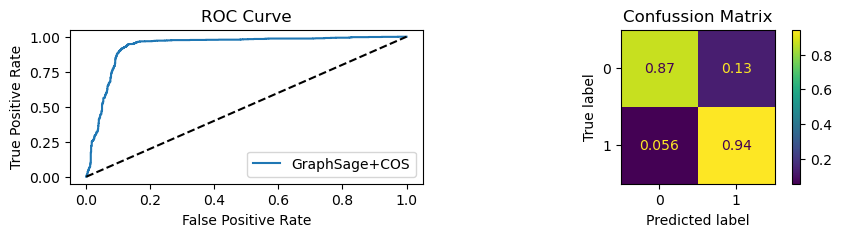

In [7]:
test_accuracy = evaluate(embed_model ,link_predictor,data_test_embed,data_test_predict,data_sample=data,threshold=0.5,show_extra_metrics=True)
#torch.save(test_accuracy, 'test_accuracy.pt')

In [8]:
pred,labels,head,tail,negative_edge_index = forward_pass(model= embed_model , link_predictor = link_predictor,data_embed = data_train_embed,data_predict = data_train_predict,data_sample = data,return_node_emb=True)
  

In [9]:
Links = head*tail
Links = Links.detach().numpy()


In [10]:
Links

array([[   989651.9 ,   1438947.1 ,   2146322.2 , ...,   1883078.9 ,
          3307024.8 ,   1724545.8 ],
       [   871850.7 ,   1286341.2 ,   1699991.4 , ...,   1600672.6 ,
          2931967.  ,   1377570.6 ],
       [   624124.94,    776524.75,   1249639.9 , ...,   1110500.8 ,
          1987903.4 ,   1319642.  ],
       ...,
       [ -4337815.5 ,  -8092474.5 ,  -8549720.  , ...,  -9686774.  ,
        -11785367.  ,  -4796503.  ],
       [ -2770167.8 ,  -6164378.5 ,  -5635248.  , ...,  -6133222.5 ,
         -9071706.  ,  -3817948.5 ],
       [ -1218919.5 ,  -2703431.  ,  -2633059.5 , ...,  -3407631.8 ,
         -4534641.  ,  -2018561.6 ]], dtype=float32)

In [11]:
Links.shape

(19336, 524)

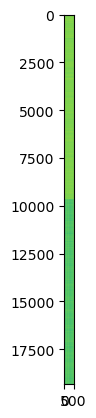

In [12]:
plt.imshow(Links)

In [13]:
normalized_matrix

NameError: name 'normalized_matrix' is not defined

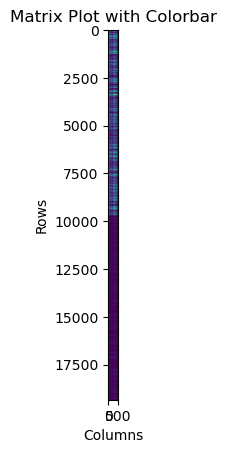

In [14]:
normalized_matrix = (Links- np.min(Links)) / (np.max(Links) - np.min(Links)) > 0.82
plt.imshow(normalized_matrix , cmap='viridis')



# Set labels and title
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Matrix Plot with Colorbar')

# Show the plot
plt.show()

In [15]:
negative_edge_index

tensor([[ 8751,  9989, 13934,  ...,  5606,  4129,  6720],
        [ 3484,  1644,   544,  ...,   845,  3192,    52]])

In [16]:
import umap

/opt/conda/envs/simp/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/envs/simp/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/envs/simp/lib/python3.11/site-packages/umap/distances.py:1086: NumbaDeprecationWarning:

In [17]:
# Create a UMAP object and fit the data
reducer   = umap.UMAP()
embedding = reducer.fit_transform(normalized_matrix)

# The embedding variable now contains the low-dimensional vectors
print(embedding.shape)  # Prints 

(19336, 2)


In [23]:
embedding.shape

(19336, 2)

In [28]:
Positive_links 

array([[ 6.346756  ,  1.2795753 ],
       [ 5.756159  ,  0.23243983],
       [ 4.315583  , -3.0544393 ],
       ...,
       [ 7.4324303 ,  3.3494027 ],
       [ 8.208641  ,  7.808576  ],
       [ 7.871845  ,  6.8989697 ]], dtype=float32)

In [29]:
Negative_links 

array([[-7.9944143,  7.9339833],
       [ 6.8527074,  2.6047213],
       [-6.8241725,  8.551886 ],
       ...,
       [-6.286882 ,  8.2812605],
       [-7.988178 ,  7.522474 ],
       [-5.122896 ,  6.9720235]], dtype=float32)

In [30]:
head.shape

torch.Size([19336, 524])

In [31]:
Positive_links = embedding[0:head.shape[0]//2,:]
Negative_links = embedding[head.shape[0]//2:,:]

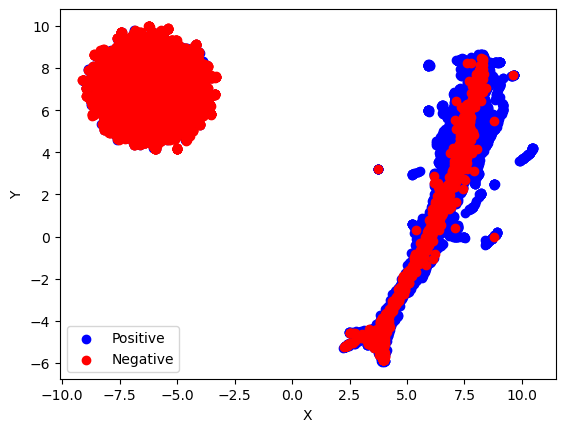

In [32]:
# Plot the positive vector with blue color
plt.scatter(Positive_links[:,0], Positive_links[:,1], color='blue', label='Positive')

# Plot the negative vector with red color
plt.scatter(Negative_links[:,0],Negative_links[:,1], color='red', label='Negative')

# Add labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Show the plot
plt.show()

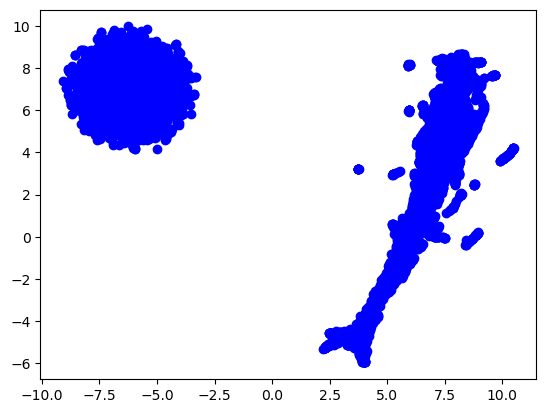

In [33]:
# Plot the positive vector with blue color
plt.scatter(Positive_links[:,0], Positive_links[:,1], color='blue', label='Positive')

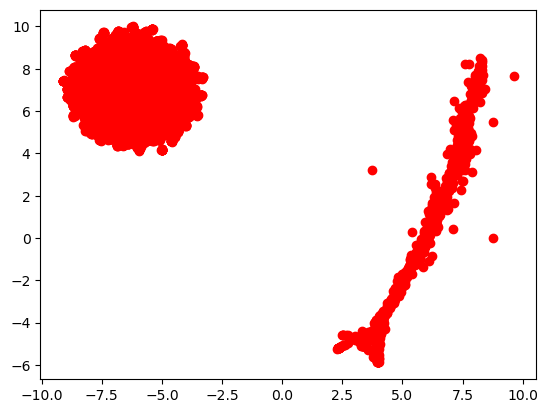

In [34]:
# Plot the negative vector with red color
plt.scatter(Negative_links[:,0],Negative_links[:,1], color='red', label='Negative')